# Parameter Sensitivity Analysis of Labeled Samples via Voronoi Cell-Boundaries
Instead of discrete sampling we compute the number of potential transitions via the Voronoi-Boundaries that describe the partitions in the parameter space.
Therefore, we need to perform the following steps:

1. Compute the Voronoi-Diagram V of the parameter space sampling P with dimensionality N. 
   
   Note: We can generalize the algorithm to work on general convex partitions instead of necessitating the Voronoi-Diagram computation.
   For arbitrary partitionings, we would subdive each partition until all partitions are convex. 
   Given their convex hulls, we can apply the same algorithm later on.

2. Clip the Voronoi-Diagram against a bounding box B, resulting in V_clipped.
3. Extract all convex hulls of the clipped Voronoi-Diagram, resulting in a set of labeled convex hulls C (labeled by the corresponding cell point label).
4. Remove all convex hulls which have no neighboring convex hulls with different label than themselves, resulting in the subset C_trans.
5. Extract all facets of the convex hulls that connect two convex hulls with different labels, resulting in set F_trans.
   
   The facets in F_trans will have dimensionality N-1 (but may consist of N+ points!)
   Each facet represents potential transitions between two different parameter space regions, which can be interpreted as transitions from one label to another.
   
   Given that N=2, the facets will always consist of two points and correspond to a (1D-) line (in 2D) with "volume" (here: length).
   For N > 2, the facets will always consist of > 2 points and will have "volume": area if N=3, Nd-volume if N > 3.
6. Given a set of sample Points S for a given Feature f and bandwidth B, for each sample point s:
   1. Clip each facet to [s - B, s + B].
   2. Project facets to the parameter in question, by removing this parameter from the facet.
   3. Add the "volume" of all facets.

In [1]:
import sys
sys.path.extend(["../../"])
from src.para_voro import *
from src.para_voro_plots import *
from matplotlib.patches import Circle

# Set the random seed for reproducibility
np.random.seed(20101)

In [2]:
# Number of samples
num_samples = 100

factor = 10

num_samples = num_samples * factor

cluster1 = np.random.randn(50*factor, 2) + [2, 2]
cluster2 = np.random.randn(30*factor, 2) + [0, 0]
mixed_cluster = np.random.randn(20*factor, 2) + [1, 1]

# Combine the samples into a single array
samples = np.vstack([cluster1, cluster2, mixed_cluster])

# Assign labels based on clusters
labels = np.array([0]*50*factor + [1]*30*factor + [0]*10*factor + [1]*10*factor)

In [3]:
# build voronoi cells
vor = Voronoi(samples)

In [4]:
# get all finite and infinite cells of the points
finite_regions = []
infinite_regions = []
for point_idx in range(len(vor.points)):
    region = vor.regions[vor.point_region[point_idx]]
    if -1 in region:
        infinite_regions.append((point_idx, region))
        continue
    
    finite_regions.append((point_idx, region))

In [5]:
# get unique lables
unique_labels = np.unique(labels)

# create colormap for labels
cmap = plt.get_cmap('plasma', len(unique_labels) + 3)  # Use 'viridis' colormap or any other
colors = cmap(np.arange(len(unique_labels))+2)

### Plotting

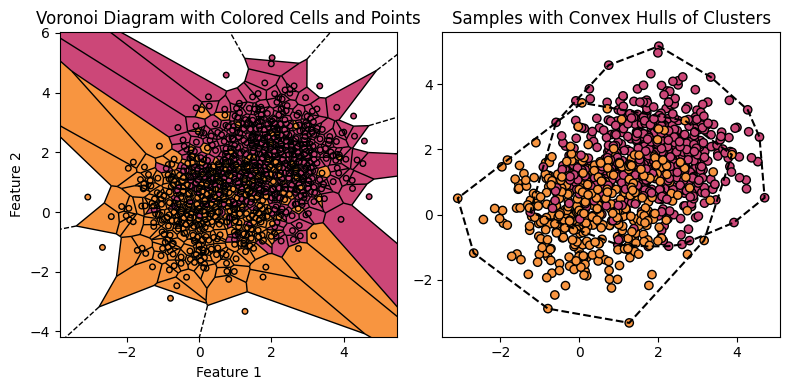

In [6]:
plt.close()
fig = plt.figure(figsize=(8, 4))

# Plotting the Voronoi diagram with colored cells and points
ax1 = fig.add_subplot(1, 2, 1)

for point_idx, region in finite_regions:
    coords = vor.vertices[region]
    p = Polygon(coords, facecolor=colors[labels[point_idx]])
    ax1.add_patch(p)

voronoi_plot_2d(vor, show_vertices=False, show_points=False, point_size=5, ax=ax1)
ax1.scatter(samples[:, 0], samples[:, 1], c=colors[labels], marker='o', edgecolors='k', s=2**4)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Voronoi Diagram with Colored Cells and Points')

# Plotting the convex hulls of each cluster
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(samples[:, 0], samples[:, 1], c=colors[labels], marker='o', edgecolors='k')
for label in np.unique(labels):
    points = samples[labels == label]
    hull = ConvexHull(points)
    hull.close()
    ax2.plot(np.append(points[hull.vertices, 0], points[hull.vertices[0], 0]), np.append(points[hull.vertices, 1], points[hull.vertices[0], 1]), 'k--')
ax2.set_title('Samples with Convex Hulls of Clusters')

fig.tight_layout()
plt.show()


In [7]:
# Extract ridges (faces) that correspond to points with different labels
face_points = vor.ridge_points

# map face_points to labels
face_labels = labels[face_points]

dividing_ridges = np.array(vor.ridge_vertices)[face_labels[:, 0] != face_labels[:, 1]]

# filter infinity ridges
dividing_ridges = dividing_ridges[np.all(dividing_ridges >= 0, 1)]

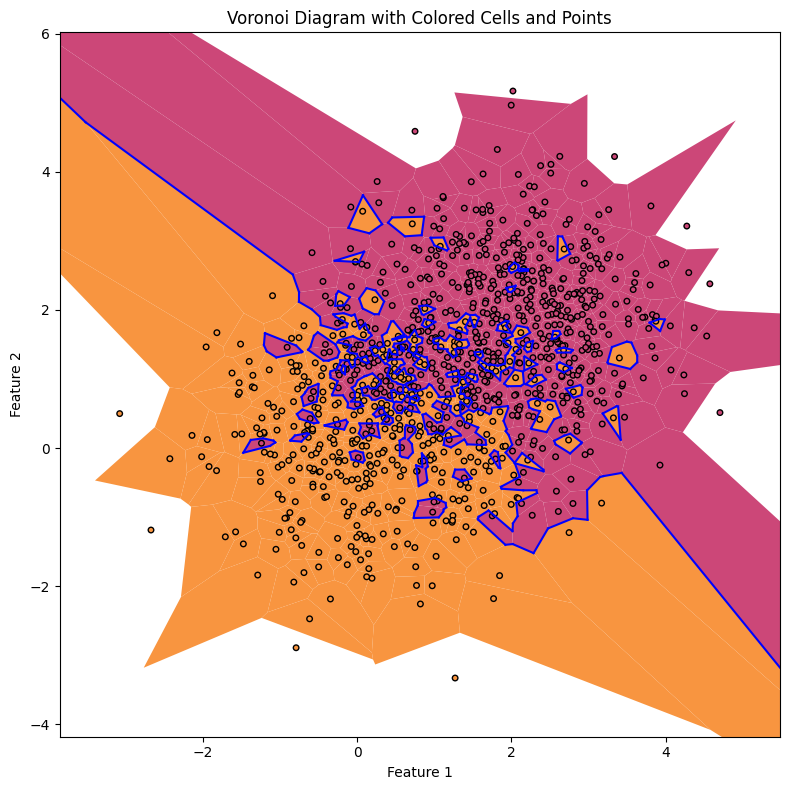

In [8]:
# plot dividing ridges
plt.close()
fig = plt.figure(figsize=(8, 8))

# Plotting the Voronoi diagram with colored cells and points
ax = fig.add_subplot(1, 1, 1)

for point_idx, region in finite_regions:
    coords = vor.vertices[region]
    p = Polygon(coords, facecolor=colors[labels[point_idx]])
    ax.add_patch(p)

# voronoi_plot_2d(vor, show_vertices=False, show_points=False, point_size=5, ax=ax)
ax.scatter(samples[:, 0], samples[:, 1], c=colors[labels], marker='o', edgecolors='k', s=2**4)

for ridge in dividing_ridges:
    ridge_vertices = vor.vertices[ridge]
    ax.plot(ridge_vertices[:, 0], ridge_vertices[:, 1], color="blue", )

ax.set_xlim(ax1.get_xlim())
ax.set_ylim(ax1.get_ylim())

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Voronoi Diagram with Colored Cells and Points')

fig.tight_layout()
plt.show()

In [9]:
# sample ridges along axis and plot their length via bandwidth
bandwidth = 0.5
axis = 0

# min_v = np.min(vor.vertices[:, axis])
# max_v = np.max(vor.vertices[:, axis])

min_v, max_v = ax.get_xlim()

sample_points = np.linspace(min_v, max_v, 1000)

res = []
for sp in sample_points:
    s = 0
    for ridge in dividing_ridges:
        ridge_vertices = vor.vertices[ridge]

        # compute absolute gradient
        dy = np.abs(ridge_vertices[0, 1-axis] - ridge_vertices[1, 1-axis])
        dx = np.abs(ridge_vertices[0, axis] - ridge_vertices[1, axis])

        if dx == 0:
            v = dy
        else:
            m = dy / dx

            # clip ridge to sample interval
            sp_min = sp - bandwidth
            sp_max = sp + bandwidth

            lower_ridge = ridge_vertices[:, axis].min()
            upper_ridge = ridge_vertices[:, axis].max()

            if upper_ridge < sp_min:
                continue
            if lower_ridge > sp_max:
                continue

            if lower_ridge < sp_min:
                lower_ridge = sp_min
            if upper_ridge > sp_max:
                upper_ridge = sp_max

            new_dx = upper_ridge - lower_ridge

            v = new_dx * m
        
        s += v
    res.append(s)

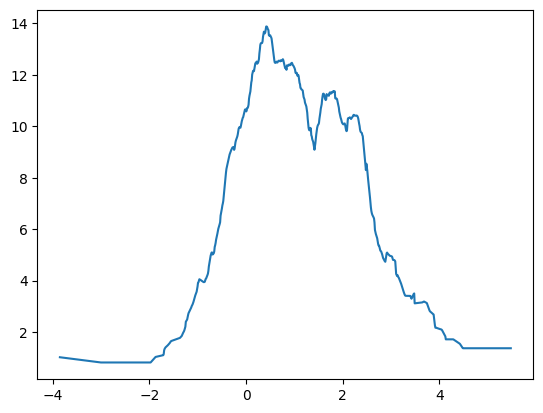

In [10]:
plt.close()
fig = plt.figure()
plt.plot(sample_points, res)
plt.show()

In [11]:
"""
Halfspaces for 1D does not work with HalfspaceIntersection
halfspaces1D = np.array([
    [-1.0, 0.0],  # a
    [1.0, -2.0],   # b
])

interior_point = np.array([1.0])

hs = HalfspaceIntersection(halfspaces=halfspaces1D, interior_point=interior_point)
"""

'\nHalfspaces for 1D does not work with HalfspaceIntersection\nhalfspaces1D = np.array([\n    [-1.0, 0.0],  # a\n    [1.0, -2.0],   # b\n])\n\ninterior_point = np.array([1.0])\n\nhs = HalfspaceIntersection(halfspaces=halfspaces1D, interior_point=interior_point)\n'

# Computing Convex Hulls with Half-Space Intersections

In [12]:
# halfspaces2D = np.array([
#     [0.0, -1.0, -0.5],  # a
#     [1.0, 0.0, -1.5],  # b
#     [0.0, 1.0, -1.5],  # c
#     [-1.0, 0.0, -1.5],  # c
# ])

halfspaces2D = construct_halfspace_definition_for_aabbox(np.array([
    [-1.5, 1.5],
    [-0.5, 1.5]
]))

halfspaces2D = halfspaces2D[[2, 1, 3, 0]]  # reorder for correct plotting

interior_point, y = get_interior_point_from_halfspaces(halfspaces2D)

hs = HalfspaceIntersection(halfspaces=halfspaces2D, interior_point=interior_point)
ch = ConvexHull(hs.intersections)
ch.volume

6.0

In [13]:
halfspaces2D

array([[ 0. , -1. , -0.5],
       [ 1. ,  0. , -1.5],
       [ 0. ,  1. , -1.5],
       [-1. ,  0. , -1.5]])

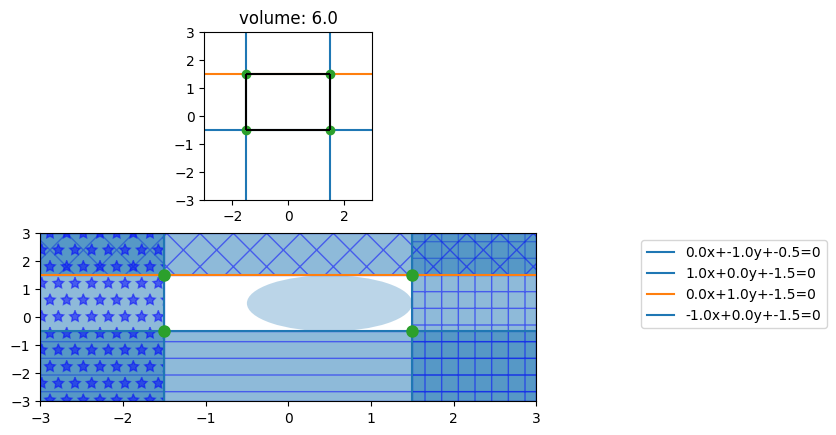

In [14]:
plt.close()
fig = plt.figure()
xlim, ylim = (-3, 3), (-3, 3)
x = np.linspace(*xlim, 100)
ax = fig.add_subplot(2, 1, 1, aspect='equal')

for h in halfspaces2D:
    hlist = h.tolist()
    if h[1]== 0:
        ax.axvline(-h[2]/h[0], label='{}x+{}y+{}=0'.format(*hlist))
    else:
        ax.plot(x, (-h[2]-h[0]*x)/h[1], label='{}x+{}y+{}=0'.format(*hlist))

convex_hull_plot_2d(ch, ax=ax)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title(f"volume: {ch.volume}")

ax = fig.add_subplot(2, 1, 2)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

symbols = ['-', '+', 'x', '*']
signs = [0, -1,-1, 0]
fmt = {"color": None, "edgecolor": "b", "alpha": 0.5}

for h, sym, sign in zip(halfspaces2D, symbols, signs):
    hlist = h.tolist()
    fmt["hatch"] = sym
    if h[1]== 0:
        ax.axvline(-h[2]/h[0], label='{}x+{}y+{}=0'.format(*hlist))
        xi = np.linspace(xlim[sign], -h[2]/h[0], 100)
        ax.fill_between(xi, ylim[0], ylim[1], **fmt)
    else:
        ax.plot(x, (-h[2]-h[0]*x)/h[1], label='{}x+{}y+{}=0'.format(*hlist))
        ax.fill_between(x, (-h[2]-h[0]*x)/h[1], ylim[sign], **fmt)
x, y = zip(*hs.intersections)
ax.plot(x, y, 'o', markersize=8)

x, y = get_interior_point_from_halfspaces(halfspaces2D)

circle = Circle(x, radius=y, alpha=0.3)
ax.add_patch(circle)
plt.legend(bbox_to_anchor=(1.6, 1.0))
plt.show()

# Generalized N-D Example

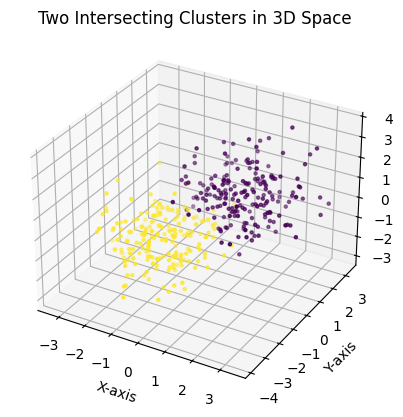

In [15]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate sample data for two intersecting clusters
np.random.seed(0)
num_samples = 200
cluster1 = np.random.randn(num_samples, 3) + [1, 1, 1]
cluster2 = np.random.randn(num_samples, 3) + [-1, -1, -1]
data = np.vstack([cluster1, cluster2])

# Add labels for the two clusters
labels = np.array([0] * num_samples + [1] * num_samples)

# Plot the data in 3D
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='viridis', s=5)

# Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show plot
plt.title('Two Intersecting Clusters in 3D Space')
plt.show()


# Rotate to lower-dimensional space that contains the facet
Each facet lives on a hyperplane in the N-dimensional space.
To compute it's convex hull, we rotate the facet vertices to match the hyperplane and drop the flat dimension.

In [16]:
def sample_plane(normal, offset, num_points=10, scaling: float = 1.0):
    """
    Samples points on a plane defined by its normal vector and offset.
    
    Args:
        normal (np.array): The normal vector to the plane [A, B, C]
        offset (float): The offset from the origin where A*x + B*y + C*z = d
        num_points (int): Number of points to sample (default is 10)
        
    Returns:
        np.array: An array of sampled points on the plane
    """
    
    # Create a basis for the plane using cross product of normal vector with some arbitrary vectors
    if np.linalg.norm(normal) != 1:
        normal = normal / np.linalg.norm(normal)  # Ensure the normal is normalized
        
    # Choose an arbitrary non-parallel vector to the normal for u
    if normal[0] != 0:
        u_vec = np.array([-normal[1]/normal[0], 1, 0])
    elif normal[1] != 0:
        u_vec = np.array([1, -normal[0]/normal[1], 0])
    else:
        u_vec = np.array([1, 0, -normal[0]/normal[2]])
    
    u_vec = u_vec / np.linalg.norm(u_vec)  # Normalize the vector u
        
    v_vec = np.cross(normal, u_vec)  # Get the orthogonal basis vector v
    
    s, t = np.meshgrid(np.linspace(-1, 1, num_points), np.linspace(-1, 1, num_points))

    point = -offset * normal  # the offsetted origin in normal direction

    points = point + scaling * s[:, :, np.newaxis] * u_vec + scaling * t[:, :, np.newaxis] * v_vec
    
    return points

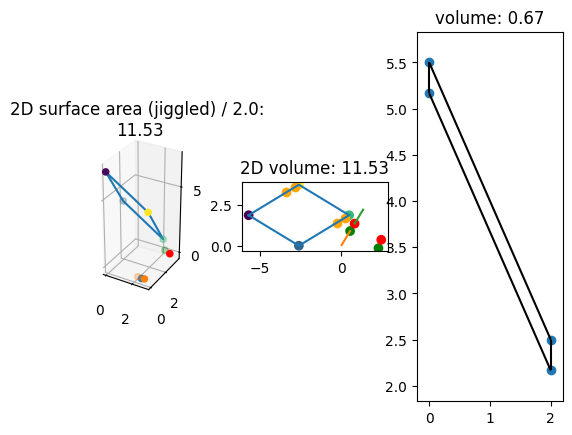

In [17]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

c = 2

# surface_in_3d = np.array([
#     [0.0, 0.0, 5.0],
#     [0.0, 2.0, 0.0],
#     [3.0, 2.0, 0.0+c],
#     [3.0, 0.0, 5.0+c]
# ])

surface_in_3d = np.array([
    [0.0, 0.0, 0.0+2*c+3],
    [0.0, 2.0, 0.0+2*c],
    [3.0, 2.0, 0.0+c],
    [3.0, 0.0, 0.0+c+3]
])

s3ds = np.vstack([surface_in_3d, surface_in_3d[:1, :]])

colors = np.arange(10)
labels = ["lower", "upper"]

plt.close()
# %matplotlib widget
fig = plt.figure()
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(surface_in_3d[:, 0], surface_in_3d[:, 1], surface_in_3d[:, 2], c=colors[:4])
ax1.plot(s3ds[:, 0], s3ds[:, 1], s3ds[:, 2])

# plot halfspaces around sample point
sample_point = np.array([2.5, 0.0, 0.0])
ax1.scatter(sample_point[0], sample_point[1], sample_point[2])

bandwidth = np.array([0.25, 0.0, 0.0])
lower_dim, upper_dim = sample_point - bandwidth, sample_point + bandwidth

lower_upper_points = np.vstack([lower_dim, upper_dim])
ax1.scatter(lower_upper_points[:, 0], lower_upper_points[:, 1], lower_upper_points[:, 2])

hs_lower, hs_upper = make_halfspaces(lower_dim[0], upper_dim[0], 3, 0)
hs_points_lower, hs_points_upper = sample_plane(hs_lower[:-1], hs_lower[-1], scaling=4), sample_plane(hs_upper[:-1], hs_upper[-1], scaling=4)
#ax1.plot_surface(hs_points_lower[..., 0], hs_points_lower[..., 1], hs_points_lower[..., 2])
#ax1.plot_surface(hs_points_upper[..., 0], hs_points_upper[..., 1], hs_points_upper[..., 2])

# R = rotate_to_lower_dimensional_hyperplane(surface_in_3d)
_, _, Vh = rotate_to_lower_dimensional_hyperplane(surface_in_3d, return_full=True)

normal_of_plane = Vh[-1, :]
offset_of_plane = (normal_of_plane @ surface_in_3d[0])

# plot normal of plane
normal_points = np.vstack([
    surface_in_3d[0, :],
    surface_in_3d[0, :] + 1 * normal_of_plane,
])
#ax1.plot(normal_points[:, 0], normal_points[:, 1], normal_points[:, 2])
o1_points = np.vstack([
    surface_in_3d[0, :],
    surface_in_3d[0, :] + 1 * Vh[0, :],
])
o2_points = np.vstack([
    surface_in_3d[0, :],
    surface_in_3d[0, :] + -1 * Vh[1, :],
])
#ax1.plot(o1_points[:, 0], o1_points[:, 1], o1_points[:, 2])
#ax1.plot(o2_points[:, 0], o2_points[:, 1], o2_points[:, 2])

#surface_plane = sample_plane(normal_of_plane, offset_of_plane, scaling=10)
#ax1.plot_surface(surface_plane[..., 0], surface_plane[..., 1], surface_plane[..., 2])

R = Vh.T

#svd = TruncatedSVD(n_components=surface_in_3d.shape[-1]-1)
#surface_in_2d = svd.fit_transform(surface_in_3d)
surface_in_2d = (surface_in_3d @ R)
depth_of_plane = surface_in_2d[0, -1]
surface_in_2d = surface_in_2d[:, :-1]

dir_x_2d = (Vh[0, :] @ R)[:-1]
dir_y_2d = (Vh[1, :] @ R)[:-1]

# surface_in_2d = surface_in_2d @ np.diag([rescaling_x, rescaling_y])

ax2 = fig.add_subplot(132)
ch = ConvexHull(surface_in_2d)
# convex_hull_plot_2d(ch, ax2)
si2ds = np.vstack([surface_in_2d, surface_in_2d[0]])
ax2.plot(si2ds[:, 0], si2ds[:, 1])
ax2.scatter(surface_in_2d[:, 0], surface_in_2d[:, 1], c=colors[:4])

# get halfspaces of convex hull
#dir_x_points = np.vstack([
#    surface_in_2d[0], (surface_in_2d[0, :] + dir_x_2d)
#])
#dir_y_points = np.vstack([
#    surface_in_2d[0], (surface_in_2d[0, :] + dir_y_2d)
#])
# ax2.plot(dir_x_points[:, 0], dir_x_points[:, 1])
# ax2.plot(dir_y_points[:, 0], dir_y_points[:, 1])

# project normal of halfintersections
hs_l2 = hs_lower[:-1] @ R
# lhsl2 = np.linalg.norm(hs_l2[:-1])
hs_lower_norm_2d = normalize_vec(hs_l2[:-1])  # hs_l2 / lhsl2)[:-1]

hs_u2 = hs_upper[:-1] @ R
# lhsu2 = np.linalg.norm(hs_u2[:-1])
hs_upper_norm_2d = normalize_vec(hs_u2[:-1])  # (hs_u2 / lhsu2)[:-1]

assert (hs_lower_norm_2d == -hs_upper_norm_2d).all(), "they should still always point in opposite direction if computed correctly (can safe one projection)"

# compute intersecting points on the normals
p1, p2 = find_point_in_intersecting_plane(np.append(normal_of_plane, offset_of_plane), 0, lower_dim[0])[0], find_point_in_intersecting_plane(np.append(normal_of_plane, offset_of_plane), 0, upper_dim[0])[0]

# project intersecting points on 2d
l12_points = np.vstack([p1, p2])
l12_points_rotated = l12_points @ R
l12_points_2d = l12_points_rotated[:, :-1]

ax1.scatter(l12_points[:, 0], l12_points[:, 1], l12_points[:, 2], c=["green", "red"])
ax2.scatter(l12_points_2d[:, 0], l12_points_2d[:, 1], c=["green", "red"])

# compute offset of projected halfintersections
ol2d, ou2d = get_plane_offset_from_normal_and_point_in_plane(hs_lower_norm_2d, l12_points_2d[0]), get_plane_offset_from_normal_and_point_in_plane(hs_upper_norm_2d, l12_points_2d[1])

# plot halfintersection normals
hsl_origin = ol2d * hs_lower_norm_2d
hsu_origin = ou2d * hs_upper_norm_2d

fh = 1.0

ax2.scatter([hsl_origin[0], hsu_origin[0]], [hsl_origin[1], hsu_origin[1]], c=["green", "red"], label=labels)
ax2.plot([hsl_origin[0], hsl_origin[0] + fh * hs_lower_norm_2d[0]], [hsl_origin[1], hsl_origin[1] + fh * hs_lower_norm_2d[1]], label="lower norm")
ax2.plot([hsu_origin[0], hsu_origin[0] + fh * hs_upper_norm_2d[0]], [hsu_origin[1], hsu_origin[1] + fh * hs_upper_norm_2d[1]], label="upper norm")
#plt.legend()
# create new halfintersections object
equations = ch.equations

# add equations to cut it
equations = np.vstack([equations, np.append(hs_lower_norm_2d, -ol2d), np.append(hs_upper_norm_2d, -ou2d)])

# get interior point
interior_point_2d = get_interior_point_from_halfspaces(equations)[0]

# compute halfspace intersections
hs_2d = HalfspaceIntersection(halfspaces=equations, interior_point=interior_point_2d)

# new intersection points
intersection_points_2d = hs_2d.intersections

ax2.scatter(intersection_points_2d[:, 0], intersection_points_2d[:, 1], c="orange")

# rotate back to 3D
intersection_points_3d = np.column_stack([intersection_points_2d, np.ones(len(intersection_points_2d)) * depth_of_plane]) @ R.T

# plot in 3d
#ax1.scatter(intersection_points_3d[:, 0], intersection_points_3d[:, 1], intersection_points_3d[:, 2])

# project on n-1 dim without the axis of question
intersection_points_2d_proj = intersection_points_3d[:, 1:]

# compute new convex hull
ch22 = ConvexHull(intersection_points_2d_proj)

# plot final convex hull
ax4 = fig.add_subplot(133)
convex_hull_plot_2d(ch22, ax=ax4)

ax4.set_title(f"volume: {ch22.volume:.2f}")

# The jiggled 3d points create a almost flat volume. 
# It's surface area should correspond to almost double the area (2D-volume) of the projection (twice the face plus the jiggled sides).
ch3 = ConvexHull(surface_in_3d, qhull_options="QJ")
ax1.set_title(f"2D surface area (jiggled) / 2.0: \n{ch3.area / 2:.2f}")

ax2.set_title(f"2D volume: {ch.volume:.2f}")

ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()

In [18]:
intersection_points_2d

array([[-0.28388749,  1.40312152],
       [ 0.22981368,  1.7149263 ],
       [-3.36609449,  3.27395021],
       [-2.85239332,  3.585755  ]])

In [19]:
chIn2D = ConvexHull(intersection_points_2d)

In [20]:
chIn2D.volume

1.9220937657784665

In [22]:
normal_of_plane

array([0.34684399, 0.78039897, 0.52026598])

In [44]:
(normal_of_plane @ np.array([1.0, 0.0, 0.0])) * chIn2D.volume

np.float64(0.6666666666666665)